# Auction exercise

We participate in auctions for items characterized by x. In these auctions  each potential buyer must place a single bid, unaware of competitors' bids. The item is awarded to the highest bidder at the price offered. In other words, if we place a bid z and win the auction our costs are equal to z.

The outcomes from the auctions participated are provided in an aggregated format per item. The attached file provides the raw data for a set of auctions participated.

Objectives:
1. Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.
2. Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?
3. Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn.metrics as sk_m

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from scipy.stats import gaussian_kde, uniform

In [2]:
random_state = 7
rgn = np.random.default_rng(random_state)

In [3]:
def plot_scores(y_true, y_scores, n_classe:int=2, classe_name=None, modelname='') :
    """
    Arguments :
    Plot the confusion Matrix and different scores
    y_true (array) : Ground truth (correct) target values.
    y_scores (array) : Estimated probabilities to get the target 1 returner by a binary classifier.
    """
    # y_pred (array) : Estimated targets as returned by a classifier.
    y_pred = np.array([0 if x < 0.5 else 1 for x in y_scores])
    
    N_test = len(y_pred)
    cm = sk_m.confusion_matrix(y_true, y_pred)
    cm_bis = cm.flatten()
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f"{v : 0.0f}" for v in cm_bis]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    if classe_name is None :
        classe_name = list(range(n_classe))
        
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=classe_name, yticklabels=classe_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(f"Classification report of the model for this testing set")
    print(sk_m.classification_report(y_true, y_pred, digits=3))
    print('-'*55)
    print(f"Matthews correlation coefficient: {sk_m.matthews_corrcoef(y_true, y_pred):.3}")
    print('-'*55 + '\n')

## Data preparation

In [4]:
df_data = pd.read_csv("auctions_summary.csv", delimiter=',')
print("Data overview")
display(df_data[:5])

Data overview


,x,bid,auctions,wins
0,0.585202,2.719391,7,7
1,4.567498,2.688336,2,2
2,1.481628,0.200173,4,0
3,0.828790,0.187734,4,0
4,1.988679,5.792509,7,7


We consider that:
- `x` is the param of the item
- `bid` is the bid we make for this `x`
- `auctions` is the number of auctions we participate with `(x,bid)`
- `wins` is the number of wins we made over `auctions` with `(x,bid)`

In [5]:
df_data["losses"] = df_data["auctions"] - df_data["wins"]
df_data["wins_ratio"] = df_data["wins"] / df_data["auctions"]
print("Data statistics")
df_data.describe()

Data statistics


,x,bid,auctions,wins,losses,wins_ratio
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.866859,1.581527,5.093069,2.190099,2.902970,0.417230
std,1.747467,1.554054,2.224782,2.727633,2.808097,0.454676
min,0.028227,-1.680578,1.000000,0.000000,-3.000000,0.000000
25%,1.256365,0.384293,3.000000,0.000000,0.000000,0.000000
50%,2.862625,0.944562,5.000000,1.000000,3.000000,0.166667
75%,4.394171,2.421456,6.000000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.500000


We assume that the bid is positive, and that we can't win more time that we've participated auctions for a given `(x,bid)`.  
We remove these inconsistent data from the dataset.

In [6]:
df_data = df_data[(df_data["bid"] >= 0) & (df_data["wins_ratio"] <= 1)]

In [7]:
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.856842,1.598030,5.098000,2.166000,2.932000,0.411617
std,1.747752,1.546013,2.228526,2.709451,2.796967,0.449939
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000
25%,1.242002,0.392008,3.000000,0.000000,0.000000,0.000000
50%,2.860087,0.958994,5.000000,1.000000,3.000000,0.166667
75%,4.391381,2.433355,6.250000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000


## Data visualization

In [8]:
print(f"Ratio of number of auctions win: {df_data['wins'].sum()/df_data['auctions'].sum():.2%}")

Ratio of number of auctions win: 42.49%


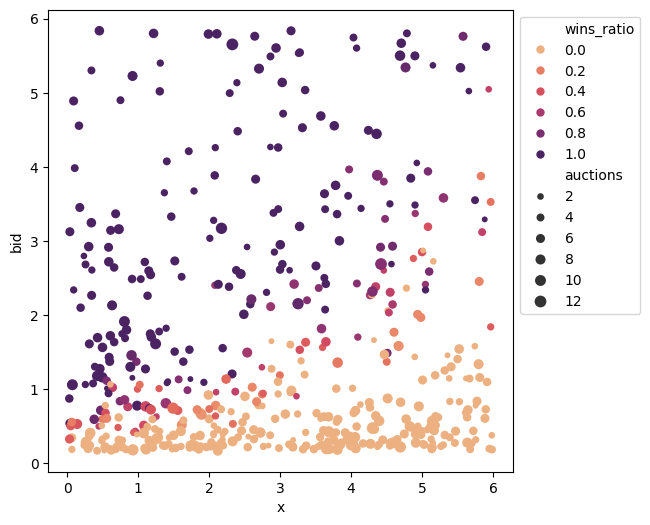

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.despine(f, left=True, bottom=True)
sns.scatterplot(
    x="x", y="bid", hue="wins_ratio", size="auctions",
    palette="flare", linewidth=0, data=df_data, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Data seems to not be well reparted, we don't have a lot with high bid.  
The decision boundary (where the ratio of winning > 0.5) looks not linear.  

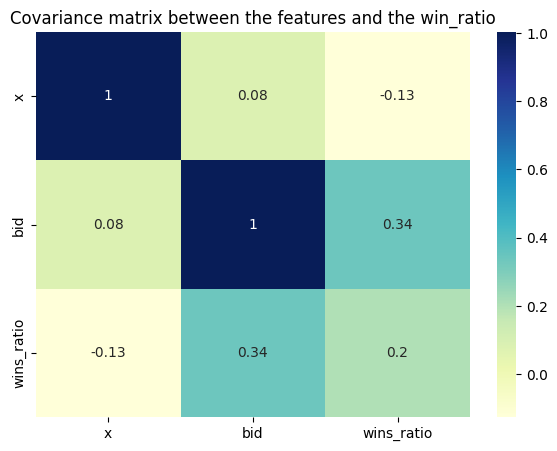

In [10]:
from sklearn.preprocessing import StandardScaler

df_data_norm = df_data.copy()
df_data_norm[["x", "bid"]] = StandardScaler().fit_transform(df_data_norm[["x", "bid"]])

cov = np.cov(df_data_norm[["x", "bid", "wins_ratio"]], rowvar=False)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    cov, annot=True, cmap="YlGnBu",
    ax=ax, xticklabels=["x", "bid", "wins_ratio"], yticklabels=["x", "bid", "wins_ratio"]
)
ax.set_title("Covariance matrix between the features and the win_ratio")
plt.show()

This matrix gives us the most correlated entries, and in particular which entries are the most correlated with the target (wins_ratio). Here we can see that the `bid` is strongly correlated to the target compared to the feature `x`.

### Data split

We assume that the result of the auctions are independent from the others. The bids are also independent from each other.

In [11]:
df_data.loc[:, ["win"]] = df_data.loc[:, ["wins", "losses"]].apply(lambda s: [0]*s['losses'] + [1]*s['wins'], axis=1)
df_data_expanded = df_data.explode("win", ignore_index=True)\
    .astype({"win": int})\
    .sample(frac=1)
df_data_expanded.describe()

,x,bid,auctions,wins,losses,wins_ratio,win
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,2.811986,1.614155,6.070224,2.604943,3.465281,0.424872,0.424872
std,1.732706,1.574560,2.226255,3.076802,3.181961,0.451324,0.494421
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.178089,0.407546,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.807454,0.932589,6.000000,1.000000,3.000000,0.200000,0.000000
75%,4.346854,2.426483,7.000000,5.000000,6.000000,1.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000,1.000000


### Data distribution

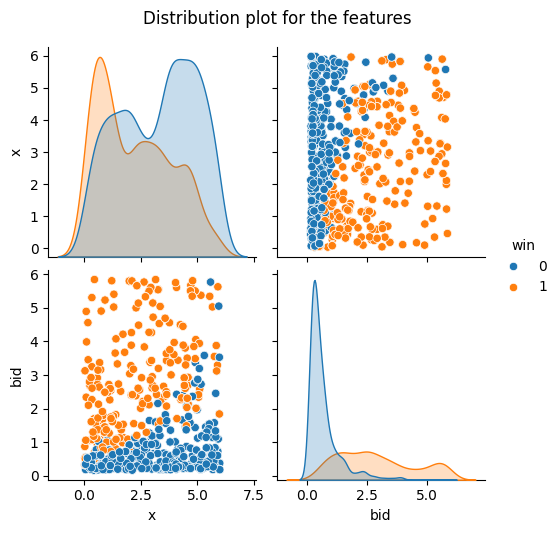

In [12]:
f = sns.pairplot(
    df_data_expanded, hue="win", vars=("x", "bid")
)
f.figure.suptitle("Distribution plot for the features", y=1.05)
plt.show()

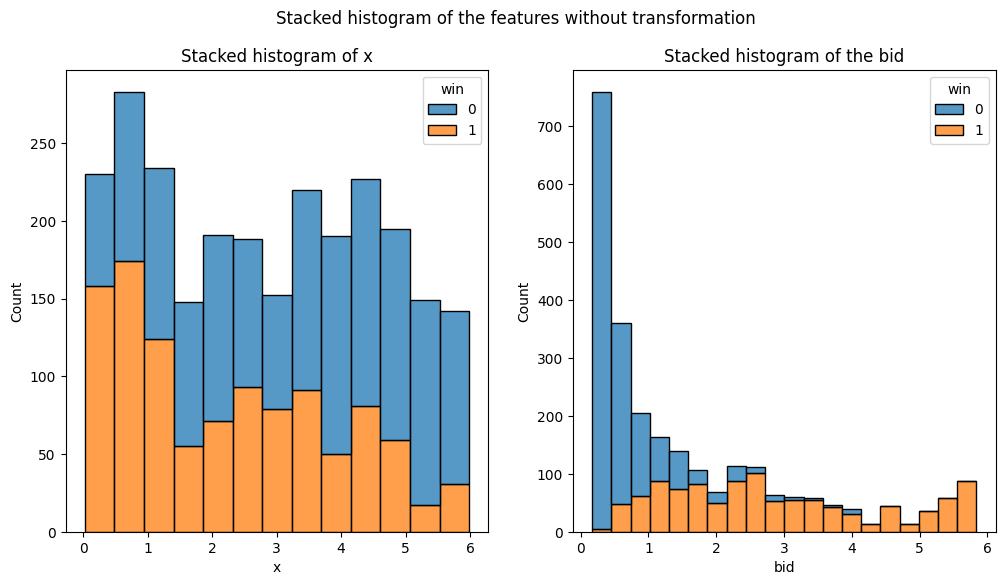

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(
    df_data_expanded, x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    df_data_expanded, x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
axs[0].set_title("Stacked histogram of x")
axs[1].set_title("Stacked histogram of the bid")
fig.suptitle("Stacked histogram of the features without transformation")
plt.show()

The data are not following a gaussian distribution, and as shown in the first graphical representation the bids are not well distributed.

## Training and exploration

In [14]:
X = df_data_expanded[["x", "bid"]].to_numpy()
y = df_data_expanded["win"].to_numpy()
n_data = len(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

#### Data transformation

In [16]:
from sklearn.preprocessing import PowerTransformer

Yeo-Johnson or Box-Cox transformation, to have a better distribution of the data

In [17]:
# pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt = PowerTransformer(method='box-cox', standardize=True)
X_train_transform = pt.fit_transform(X_train)
X_val_transform = pt.transform(X_val)
X_test_transform = pt.transform(X_test)
X_transform = pt.transform(X)

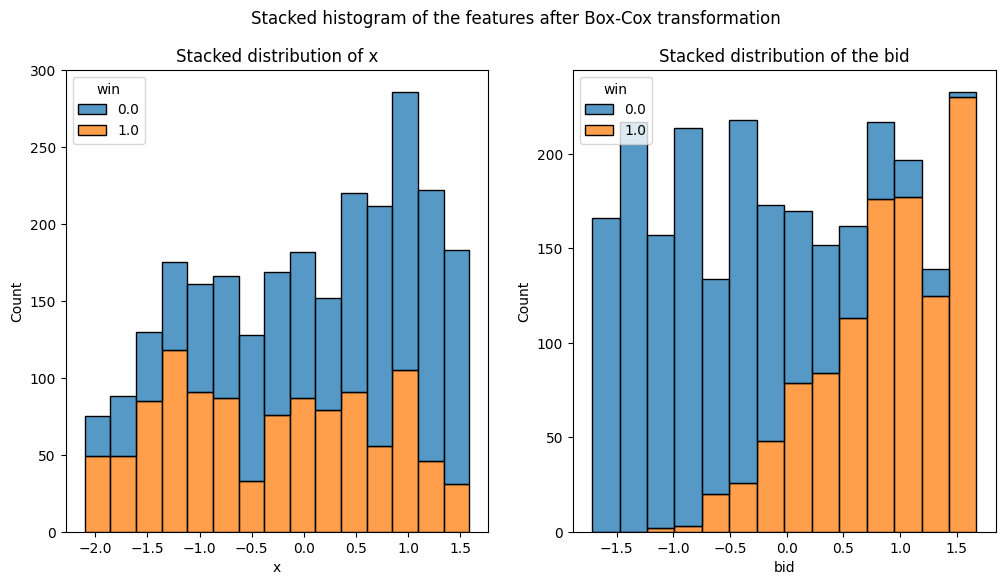

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 0, None], y[:, None])),
        columns=("x", "win")
    ), x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 1, None], y[:, None])),
        columns=("bid", "win")
    ), x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
axs[0].set_title("Stacked distribution of x")
axs[1].set_title("Stacked distribution of the bid")
fig.suptitle("Stacked histogram of the features after Box-Cox transformation")
plt.show()

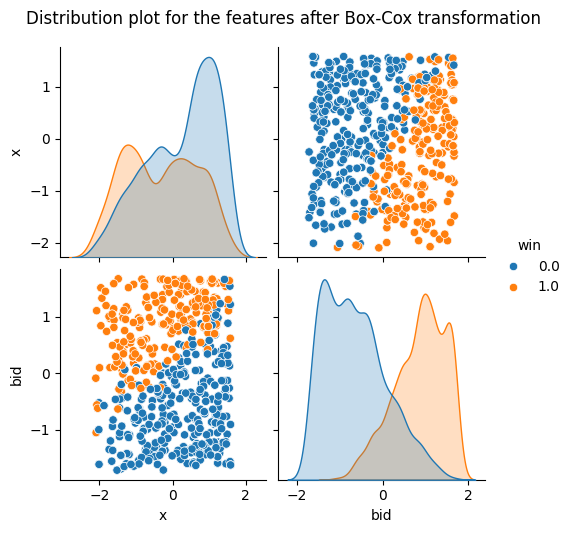

In [19]:
df_data_expanded_trans = pd.DataFrame(
    np.hstack((X_transform, y[:, None])),
    columns=("x", "bid", "win")
)

f = sns.pairplot(
    df_data_expanded_trans, hue="win", vars=("x", "bid")
)
f.figure.suptitle("Distribution plot for the features after Box-Cox transformation", y=1.05)
plt.show()

### Training

In [20]:
early_stopping = lgb.early_stopping(stopping_rounds=10)
kfold = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

Which model is the best doing only a basic training, without doing any hyperparameter tuning.

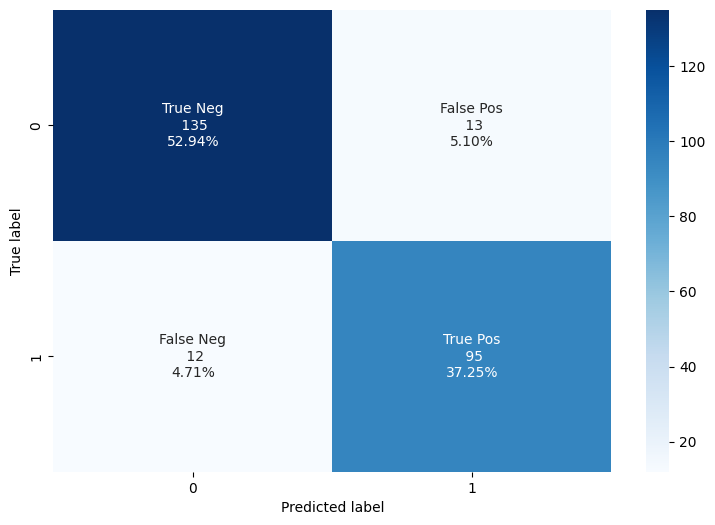

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.918     0.912     0.915       148
           1      0.880     0.888     0.884       107

    accuracy                          0.902       255
   macro avg      0.899     0.900     0.899       255
weighted avg      0.902     0.902     0.902       255

-------------------------------------------------------
Matthews correlation coefficient: 0.799
-------------------------------------------------------



In [21]:
#QDA for classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_clf = QuadraticDiscriminantAnalysis(store_covariance=True)\
    .fit(X_train_transform, y_train)

y_scores = qda_clf.predict_proba(X_test_transform)
plot_scores(y_test, y_scores[:, 1])


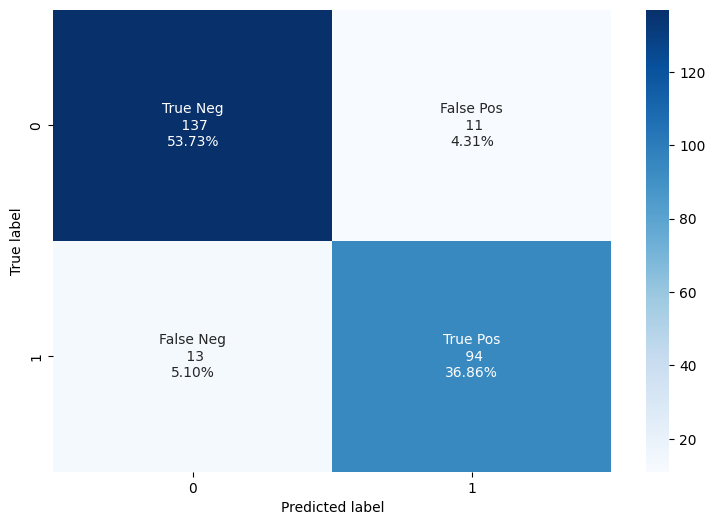

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.913     0.926     0.919       148
           1      0.895     0.879     0.887       107

    accuracy                          0.906       255
   macro avg      0.904     0.902     0.903       255
weighted avg      0.906     0.906     0.906       255

-------------------------------------------------------
Matthews correlation coefficient: 0.806
-------------------------------------------------------



In [22]:
# Logistic Regression for classification
from sklearn.linear_model import LogisticRegressionCV

lr_clf = LogisticRegressionCV(cv=10, max_iter=200, random_state=random_state)\
    .fit(X_train_transform, y_train)

y_scores = lr_clf.predict_proba(X_test_transform)
plot_scores(y_test, y_scores[:,1])

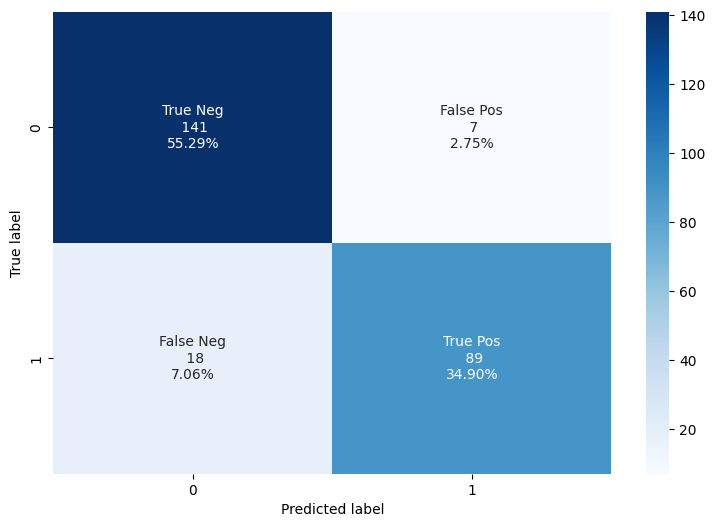

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.887     0.953     0.919       148
           1      0.927     0.832     0.877       107

    accuracy                          0.902       255
   macro avg      0.907     0.892     0.898       255
weighted avg      0.904     0.902     0.901       255

-------------------------------------------------------
Matthews correlation coefficient: 0.799
-------------------------------------------------------



In [23]:
# Small MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(early_stopping=True, random_state=random_state)\
    .fit(X_train, y_train)

y_scores = mlp_clf.predict_proba(X_test)
plot_scores(y_test, y_scores[:, 1])

In [24]:
# LGBM Classifier with CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_results = cross_val_score(lgbm_clf, X_train, y_train, cv=kfold)
print(f"\nAccuracy: {lgbm_results.mean():.2%} ({lgbm_results.std():.2%})")

[LightGBM] [Info] Number of positive: 779, number of negative: 1056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424523 -> initscore=-0.304232
[LightGBM] [Info] Start training from score -0.304232
[LightGBM] [Info] Number of positive: 779, number of negative: 1056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424523 -> initscore=-0.304232
[LightGBM] [Info] Start training from score -0.304232
[LightGBM] [Info] Number

[LightGBM] [Info] Number of positive: 866, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424718 -> initscore=-0.303435
[LightGBM] [Info] Start training from score -0.303435
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.166501


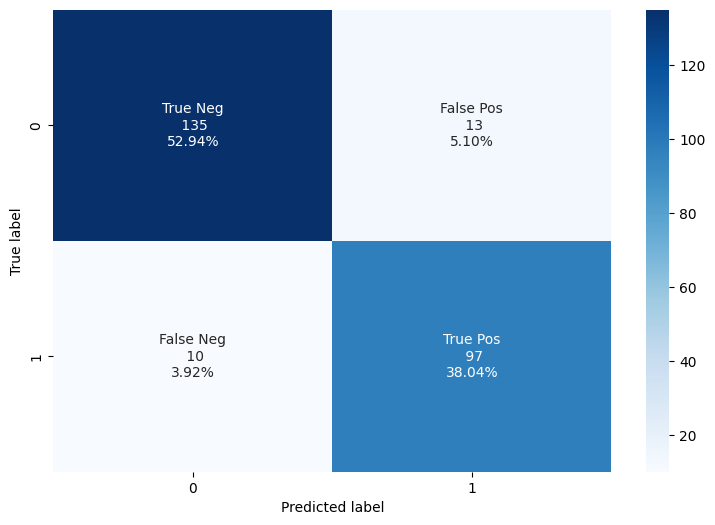

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.931     0.912     0.922       148
           1      0.882     0.907     0.894       107

    accuracy                          0.910       255
   macro avg      0.906     0.909     0.908       255
weighted avg      0.910     0.910     0.910       255

-------------------------------------------------------
Matthews correlation coefficient: 0.816
-------------------------------------------------------



In [25]:
# LGBM Classifier without CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping]
)
y_scores = lgbm_clf.predict(X_test)
plot_scores(y_test, y_scores)

In [26]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'metric': 'binary_logloss',
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': 7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 878, number of negative: 1186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 878, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

d:\Loan\Documents\Code\exercise_auction\devenv\lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Early stopping, best iteration is:
[41]	cv_agg's valid binary_logloss: 0.196928 + 0.040711


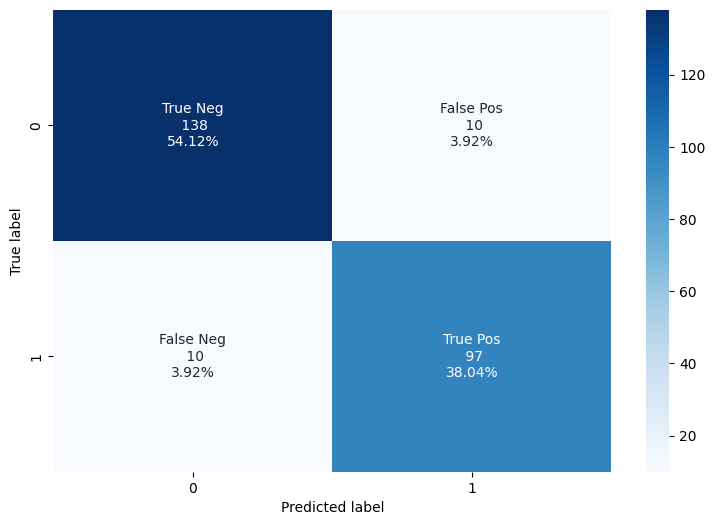

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.932     0.932     0.932       148
           1      0.907     0.907     0.907       107

    accuracy                          0.922       255
   macro avg      0.919     0.919     0.919       255
weighted avg      0.922     0.922     0.922       255

-------------------------------------------------------
Matthews correlation coefficient: 0.839
-------------------------------------------------------



In [27]:
lgbm_cv = lgb.cv(
    params,
    lgb.Dataset(
        data=np.vstack((X_train, X_val)),
        label=np.hstack((y_train, y_val)),
        feature_name=['x', 'bid']
    ),
    folds=kfold,
    callbacks=[early_stopping],
    return_cvbooster=True
)
lgbm_clf_cv = lgbm_cv['cvbooster'].boosters[-1]

y_pred = lgbm_clf_cv.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

To test our models, we fix the value of `x` 4 times, and we take samples from a larger bid distribution (up to 20 for example).
We will look at how our models behave for value of bids that we've never seen during the training.

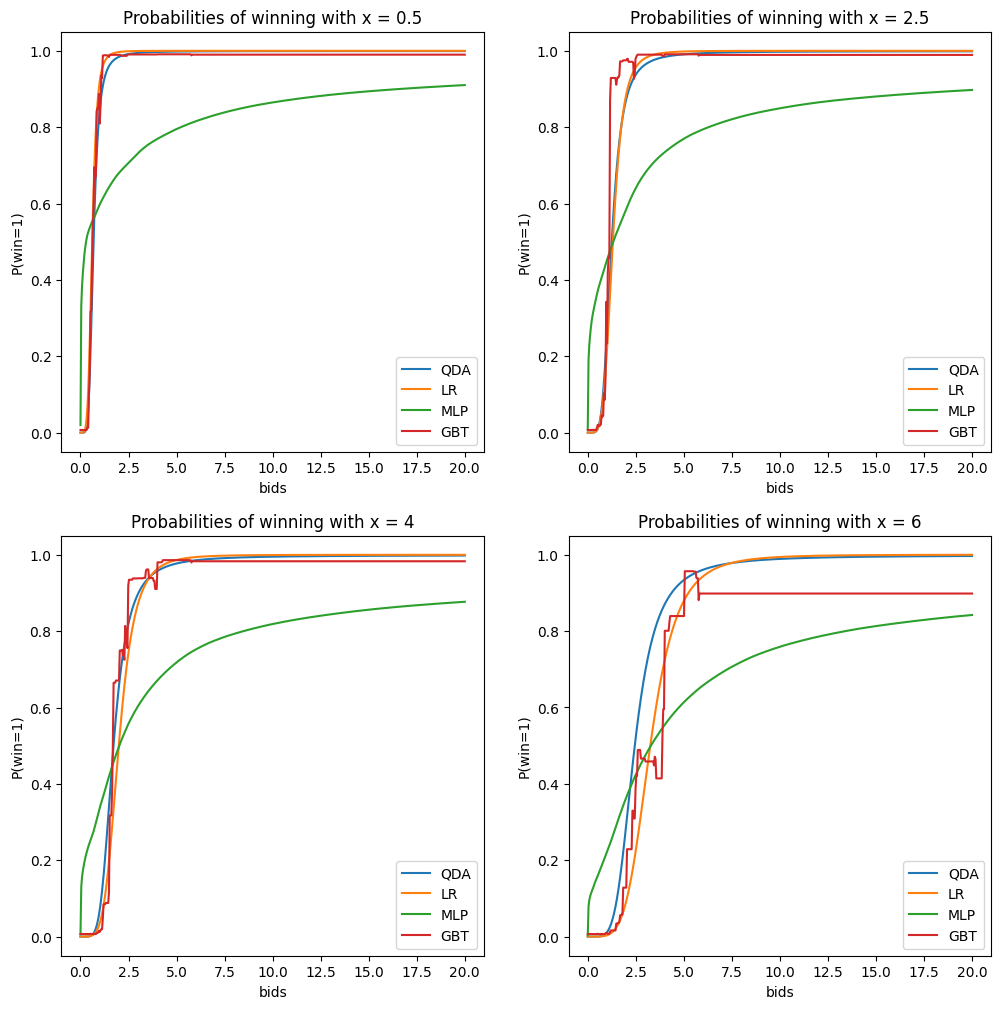

In [28]:
N = 500
x_fixed = (0.5, 2.5, 4, 6)
bid_min, bid_max = 1e-5, 20
bids = np.linspace(bid_min, bid_max , N)

models = (
    (qda_clf, "QDA", True),
    (lr_clf, "LR", True),
    (mlp_clf, "MLP", True),
    (lgbm_clf_cv, "GBT", False)
)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

for i, x_value in enumerate(x_fixed):
    X_density = np.hstack((np.full((N, 1), x_value), bids[:, None]))
    X_density_transform = pt.transform(X_density)
    
    for (model, name, need_transformed) in models:
        y_pred = model.predict_proba(X_density_transform)[:, 1] if need_transformed else model.predict(X_density)
        axs[i].plot(bids, y_pred, label=name)
        axs[i].legend()
        axs[i].set_title(f"Probabilities of winning with x = {x_value}")
        axs[i].set_xlabel(f"bids")
        axs[i].set_ylabel(f"P(win=1)")

Only looking at the scores, the best model to be the lgb, classifier model trained with CV on residuals with the full training data (`X_train` + `X_val`).  
The metrics we looked at are the f1-score on both classes, and the Matthews correlation coefficient.

However, when looking at how the probability of winning is defined for bids we didn't see in the training data set and that are high, the Logistic Regression classifier is better.

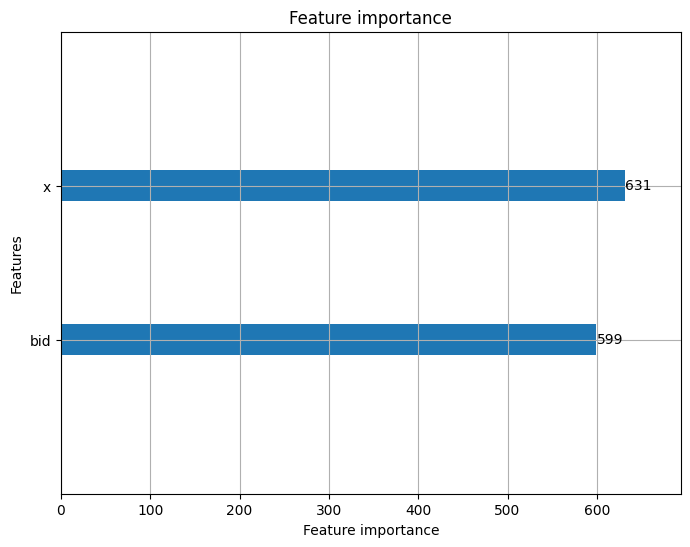

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

lgb.plot_importance(lgbm_clf_cv, ax=ax)
plt.show()

Despite having a low correlation with the `wins_ratio`, the feature `x` as the biggest importance in the construction of the gradient boosted trees.

## Probability density function for the winning bids for `x=3`

We look for the probability density function `f(bid,x=3,win=1)`.  
The PDF is specifying the probability of the a random variable that is taking its values in the possible bids for winning auctions with `x=3`, to fall within a particular range of bids.

We consider that the possible bid are between the minimum and maximum bids that we observed  in the full dataset and that we considered consistent. 

In [30]:
N = 5000
bid_min, bid_max = 1e-5, 20
bids = np.linspace(bid_min, bid_max , N)
X_density3 = np.hstack((np.full((N, 1), 3), bids[:, None]))

# We apply box-cox transform to simulated data to predict auctions results based on our model
X_density3_transform = pt.transform(X_density3)
y_density3 = lr_clf.predict_proba(X_density3_transform)[:, 1]

pdf_y = np.diff(y_density3) / np.diff(bids)
pdf_x = (bids[:-1] + bids[1:]) / 2

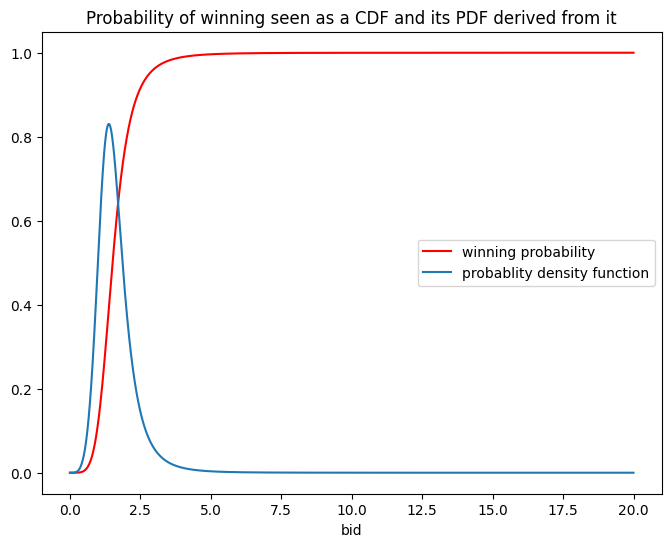

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bids, y_density3, 'r', label="winning probability")
ax.plot(pdf_x, pdf_y, label="probablity density function")
ax.set_xlabel("bid")
ax.set_title("Probability of winning seen as a CDF and its PDF derived from it")
ax.legend()
plt.show()

In [32]:
p1_to_2 = y_density3[np.logical_and(1 < bids, bids < 2)]

print(f"P(1 <= bid <= 2 | x=3,  win=1) \u2248 {p1_to_2[-1] - p1_to_2[0]:.2}")

P(1 <= bid <= 2 | x=3,  win=1) ≈ 0.67


## Cost computation

In [33]:
real_cost = np.sum(X[:, 1] * y)

We do a Monte Carlo simulation with `n_simulations` auctions sets, using our model to probabilities to get samples of won auctions associated to known `(x,bid)`.
We then compute the costs for each sample, and compute how many of them are higher than the real cost.

The probability of having a higher cost is obtained using the law of the large numbers.

In [34]:
n_simulations = 20000
y_pred_proba = lr_clf.predict_proba(X_transform)
samples = rgn.binomial(1, y_pred_proba[:,1], (n_simulations, n_data)).T
expected_cost_samples = np.sum(X[:, 1, None] * samples, axis=0)

In [35]:
proba_higher_cost = (expected_cost_samples >= real_cost).sum()
print(f"P(pred_costs >= real_costs) \u2248 {proba_higher_cost/n_simulations:.3%}")

P(pred_costs >= real_costs) ≈ 43.855%


Just looking at the probability of having predicting higher costs is too simple to do conclusion.  
We may also have to look at:
- the distribution of the costs
- we are the benefits of winning an auction. We can have costs a little bit higher but with huge benefits, or costs largely under the real costs but without any benefit.
- what is the probability of having costs in an interval around the real costs
- how often can we have extreme values ?

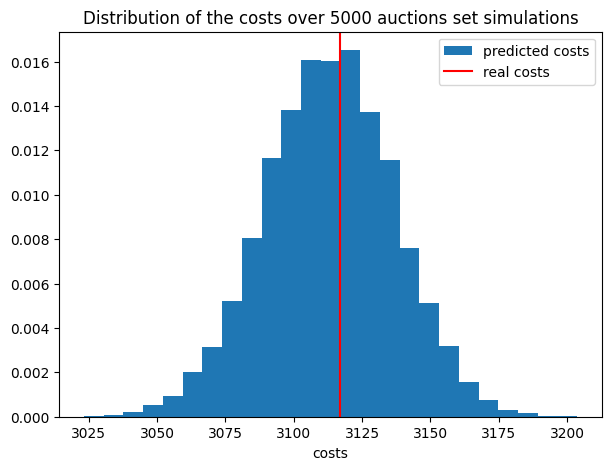

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("costs")
ax.set_title(f"Distribution of the costs over {N} auctions set simulations")
ax.hist(
    expected_cost_samples, bins=25, density=True, label='predicted costs')
ax.axvline(x=real_cost, color='r', label='real costs')
ax.legend()
plt.show()